<a href="https://colab.research.google.com/github/huytrinhx/lda-topic-modelling/blob/main/Predicting_the_usefulness_of_Amazon_Reviews_Base_Train(LDA%2BJSD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up

Mount google drive to save data and models to local google drive folder

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Establish the home drive where the saved dataset, saved models are
home_dir = '/content/gdrive/MyDrive/Data/'
data_dir = home_dir+'US_Tennis_Racquet_Reviews_Dataset.csv'

In [3]:
import numpy as np #for matrix operations
import tensorflow as tf #general tensorflows to work with amazon datasets
import tensorflow_hub as hub 
import tensorflow_datasets as tfds
import pandas as pd # for data tables manipulation
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for more fancy visualization

!pip install nltk
import nltk # library to clean and preprocess text
nltk.download("stopwords")
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
!pip install stop_words
from stop_words import get_stop_words

import gensim # library to run LDA algorithms
from gensim import corpora, models
import operator # for list operations
import pickle # for saving model and data
import random # for random generators
!pip install pyLDAvis
import pyLDAvis.gensim # for visualize LDA output
from scipy.spatial import distance # calculate Janson-Shannon Distance
from sklearn.preprocessing import MinMaxScaler # Rescale useful votes count 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # report classficiation metrics
import warnings #ignore warnings
warnings.filterwarnings('ignore')
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32919 sha256=40c7fd296d3cd6e5f3afe36244a692cd10544fd5fc02222bbaeb0f95ca2a4611
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words
     |████████████████████████████████| 1.6MB 24.0MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=2b47f77a5df8d7958cc1174fb176dd1abf359de5f2a9282c259c5e7d32e7793a
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis
Version:  2.4.0
Eager mode:  True
Hub version:  0.10.0
GPU is available


#Download the dataset (Amazon Reviews/Sports)

* Change the dataset name if your scope is different
* Only do this once and save to local drive because loading the dataset the first time is very time-consuming (take 2 hours to download and extract 832 MB)

In [ ]:
ds, info = tfds.load(name="amazon_us_reviews/Sports_v1_00", 
                        shuffle_files=True,
                        with_info=True)
print(ds)
print(info)

Filter data for only products related to tennis racqet (US market)

In [ ]:
ds_US = ds['train'].filter(lambda x: x['data']['marketplace'] == 'US')

In [ ]:
ds_Tennis = ds_US.filter(lambda x: tf.strings.regex_full_match(tf.strings.lower(x['data']['product_title']),".*tennis.*"))

In [ ]:
ds_Racquet = ds_Tennis.filter(lambda x: tf.strings.regex_full_match(tf.strings.lower(x['data']['product_title']),".*racquet.*"))

In [ ]:
tfds.as_dataframe(ds_Racquet.take(5))

Convert dataset to pandas dataframe:

In [ ]:
tennis_racquet_df = tfds.as_dataframe(ds_Racquet)
print(len(tennis_racquet_df))

In [ ]:
tennis_racquet_df.to_csv(data_dir)

#Load data from local drive

In [7]:
data = pd.read_csv(data_dir)
data.head(5)

,Unnamed: 0,data/customer_id,data/helpful_votes,data/marketplace,data/product_category,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_date,data/review_headline,data/review_id,data/star_rating,data/total_votes,data/verified_purchase,data/vine
0,0,b'20515499',1,b'US',b'Sports',b'B000OQ74FE',b'447336068',"b'HEAD Liquidmetal 4 Tennis Racquet (4-3/8), S...","b""Supposedly one of the best novice racquets. ...",b'2012-12-30',b'highly rated',b'R12VYI1R99EI1Q',5,4,0,1
1,1,b'33855426',1,b'US',b'Sports',b'B0034PBLA6',b'16849618',b'Wilson Energy Extra Large Tennis Racquet wit...,b'Wilson Energy Extra Large Tennis Racquet wit...,b'2012-10-02',b'Wilson Energy Extra Large Tennis Racquet wit...,b'R31ZPNKKOSMF2L',3,5,0,1
2,2,b'48169106',0,b'US',b'Sports',b'B006A2V4KC',b'81787317',b'Head Youtek IG Prestige Pro Tennis Racquet (...,"b""I've been playing with Head Racquets for man...",b'2014-12-21',b'Best of the Prestige frames',b'R2NOC0IE7BEWWN',5,0,0,1
3,3,b'31282127',0,b'US',b'Sports',b'B000OQBP7C',b'384056751',b'Head Liquidmetal 8 Tennis Racquet',b'I chose this racquet because its price and w...,b'2013-07-08',b'Great!!!',b'R2IDP12RDJ1SB5',5,1,0,1
4,4,b'7692919',1,b'US',b'Sports',b'B004IA8GL8',b'586581984',"b""Wilson unstrung'11 Blade Lite BLX Tennis Rac...",b'The racket is really nice for $60+. There is...,b'2013-07-14',b'Good racket',b'R2VG95KHXUZG1S',4,1,0,1


# Data Exploration

* Number of products in the dataset
* Number reviews for each

In [8]:
cols = ['data/helpful_votes','data/product_id','data/product_parent',
        'data/product_title','data/review_body','data/review_headline','data/review_id',
        'data/star_rating', 'data/total_votes']
data = data[cols]
data.head(5)

,data/helpful_votes,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_headline,data/review_id,data/star_rating,data/total_votes
0,1,b'B000OQ74FE',b'447336068',"b'HEAD Liquidmetal 4 Tennis Racquet (4-3/8), S...","b""Supposedly one of the best novice racquets. ...",b'highly rated',b'R12VYI1R99EI1Q',5,4
1,1,b'B0034PBLA6',b'16849618',b'Wilson Energy Extra Large Tennis Racquet wit...,b'Wilson Energy Extra Large Tennis Racquet wit...,b'Wilson Energy Extra Large Tennis Racquet wit...,b'R31ZPNKKOSMF2L',3,5
2,0,b'B006A2V4KC',b'81787317',b'Head Youtek IG Prestige Pro Tennis Racquet (...,"b""I've been playing with Head Racquets for man...",b'Best of the Prestige frames',b'R2NOC0IE7BEWWN',5,0
3,0,b'B000OQBP7C',b'384056751',b'Head Liquidmetal 8 Tennis Racquet',b'I chose this racquet because its price and w...,b'Great!!!',b'R2IDP12RDJ1SB5',5,1
4,1,b'B004IA8GL8',b'586581984',"b""Wilson unstrung'11 Blade Lite BLX Tennis Rac...",b'The racket is really nice for $60+. There is...,b'Good racket',b'R2VG95KHXUZG1S',4,1


In [21]:
float_cols = ['data/helpful_votes','data/total_votes']
cat_cols = ['data/product_id','data/product_parent','data/product_title','data/star_rating']

def visualize_columns(float_cols,cat_cols,final_data=final_data):
    '''
    This function visualizes all columns
      - Box-and-whisker and histogram plots for continuous variables
      - Lists of distinct values for categorical columns
    '''
    # Float columns
    for i in float_cols:
        print(i)
        fig, axs = plt.subplots(1, 2, tight_layout=True)

        sns.boxplot(data=final_data[i], ax = axs[0])

        # Print the three highest values
        highest_vals = sorted(final_data[i], reverse=True)[:3]
        print(highest_vals)
        smallest_val = round(min(final_data[i]),2)
        print(smallest_val)
        axs[0].text(smallest_val, -0.3, round(highest_vals[0],2))
        axs[0].text(smallest_val, -0.2, round(highest_vals[1],2))
        axs[0].text(smallest_val, -0.1, round(highest_vals[2],2))

        #Draw the histogram
        axs[1] = plt.hist(final_data[i],50)
        plt.show()
        
    # Categorical columns 
    for i in cat_cols:
        print(i)
        print(str(len(set(final_data[i]))) + " distinct values")
        print(final_data[i].value_counts())
        print("")
        print("")

data/helpful_votes
[595, 171, 101]
0


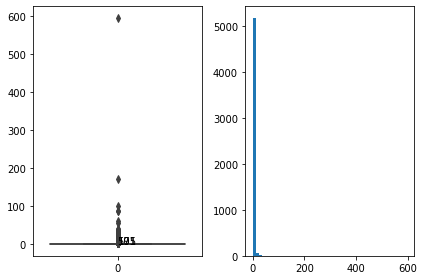

data/total_votes
[598, 177, 105]
0


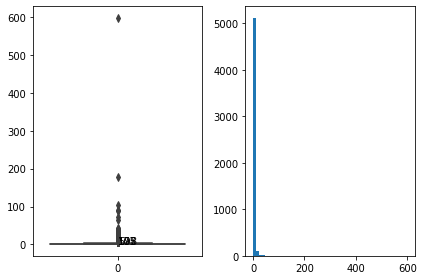

data/product_id
2186 distinct values
b'B00387ET9A'    133
b'B0007R8MHE'     95
b'B007WZZ3TE'     92
b'B000KYHMM0'     51
b'B0034PBLA6'     50
                ... 
b'B0081RQTS6'      1
b'B000G16FJ8'      1
b'B002LH330Y'      1
b'B004S7E7V4'      1
b'B00AACXLPE'      1
Name: data/product_id, Length: 2186, dtype: int64


data/product_parent
1602 distinct values
b'453459277'    159
b'245257838'    133
b'384056751'    117
b'33077627'     111
b'547332048'    109
               ... 
b'131186629'      1
b'177938855'      1
b'109228648'      1
b'123057587'      1
b'388071221'      1
Name: data/product_parent, Length: 1602, dtype: int64


data/product_title
1601 distinct values
b'Wilson US Open Junior Tennis Racquet'                                                                                                                                                                    159
b'Wilson Advantage Triple Tennis Racquet Bag (Black\\Gray)'                                                         

In [22]:
final_data = data
visualize_columns(float_cols,cat_cols,final_data)

There are ~1600 distinct product title while 2186 product ids, implying there may be multiple product id under a same product parent.

Since product parent and product title distinct counts are very similar (~1601 and ~1602), we'll go with product_parent as the grouping for our reviews aggregation in the next stage.

Also note that majority of our reviews are not voted helpful (0 helpful vote), and there are a few reviews that get really high useful vote counts (perhaps comes from products that have a lot of reviews). Since this our variable of interest, we will have to transform this vote counts and potentially play with different type of transformation later


In [24]:
#Aggregating count of reviews and total helpful votes for each products
products = final_data.groupby('data/product_parent', sort=False)
combined = products['data/helpful_votes'].agg(['count', 'sum','min','max'])
combined.sort_values(by='sum',ascending=False)

,count,sum,min,max
data/product_parent,,,,
b'453459277',159,1016,0,595
b'384056751',117,227,0,101
b'547332048',109,201,0,89
b'33077627',111,193,0,21
b'630149495',9,190,3,62
...,...,...,...,...
b'981876364',1,0,0,0
b'407107768',1,0,0,0
b'201894283',2,0,0,0


Now we need to left join the orginal data frame with this aggregate table to have some perspective on each review

In [25]:
selected_products = combined[combined['sum'] > 0]
left = pd.DataFrame(selected_products)

final_data = final_data.merge(selected_products, on='data/product_parent', how='left')
final_data.head()

,data/helpful_votes,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_headline,data/review_id,data/star_rating,data/total_votes,count,sum,min,max
0,1,b'B000OQ74FE',b'447336068',"b'HEAD Liquidmetal 4 Tennis Racquet (4-3/8), S...","b""Supposedly one of the best novice racquets. ...",b'highly rated',b'R12VYI1R99EI1Q',5,4,22.0,38.0,0.0,10.0
1,1,b'B0034PBLA6',b'16849618',b'Wilson Energy Extra Large Tennis Racquet wit...,b'Wilson Energy Extra Large Tennis Racquet wit...,b'Wilson Energy Extra Large Tennis Racquet wit...,b'R31ZPNKKOSMF2L',3,5,86.0,114.0,0.0,24.0
2,0,b'B006A2V4KC',b'81787317',b'Head Youtek IG Prestige Pro Tennis Racquet (...,"b""I've been playing with Head Racquets for man...",b'Best of the Prestige frames',b'R2NOC0IE7BEWWN',5,0,5.0,8.0,0.0,6.0
3,0,b'B000OQBP7C',b'384056751',b'Head Liquidmetal 8 Tennis Racquet',b'I chose this racquet because its price and w...,b'Great!!!',b'R2IDP12RDJ1SB5',5,1,117.0,227.0,0.0,101.0
4,1,b'B004IA8GL8',b'586581984',"b""Wilson unstrung'11 Blade Lite BLX Tennis Rac...",b'The racket is really nice for $60+. There is...,b'Good racket',b'R2VG95KHXUZG1S',4,1,6.0,6.0,0.0,2.0


Our goal is to select useful reviews from all spectrum of usefulness to make the train corpus, which will then be fed into LDA model. So the following steps is to filter out non-useful reviews

Number of reviews removed: 3170
data/helpful_votes
[595, 171, 101]
1


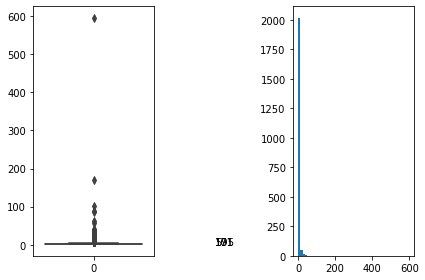

count
43 distinct values
1.0      301
2.0      252
3.0      182
4.0      113
7.0       92
5.0       88
6.0       86
10.0      65
9.0       56
117.0     56
111.0     56
51.0      49
62.0      45
14.0      45
8.0       41
159.0     40
26.0      35
92.0      35
86.0      35
11.0      34
109.0     34
16.0      31
13.0      29
28.0      28
22.0      27
37.0      22
18.0      21
133.0     21
15.0      19
31.0      18
21.0      15
12.0      15
52.0      15
19.0      13
39.0      13
17.0      13
38.0      10
23.0       7
30.0       6
24.0       6
27.0       5
25.0       5
20.0       3
Name: count, dtype: int64


sum
54 distinct values
1.0       265
2.0       208
3.0       130
4.0       128
5.0        89
6.0        71
7.0        61
10.0       61
9.0        58
227.0      56
193.0      56
8.0        52
95.0       45
14.0       43
1016.0     40
15.0       39
43.0       37
22.0       35
140.0      35
114.0      35
94.0       34
201.0      34
62.0       31
31.0       29
127.0      27
13.0       26
2

In [40]:
#Remove reviews from products that does not have any helpful votes
df = final_data[final_data['sum'] > 0]
#Remove reviews that does not have any helpful votes
df = df[df['data/helpful_votes'] > 0]

print('Number of reviews removed: '+ str(len(final_data)-len(df)))

float_cols = ['data/helpful_votes']
cat_cols = ['count','sum']
visualize_columns(float_cols,cat_cols,df)
train_df = df

We've got quite many reviews that comes from products that have little reviews or little total useful votes. Maybe the products have a short lifespan or are not very popular. Therefore, we need to remove those reviews from our train dataset to have high-quality LDA model 

Number of reviews removed: 1420
data/helpful_votes
[595, 171, 101]
1


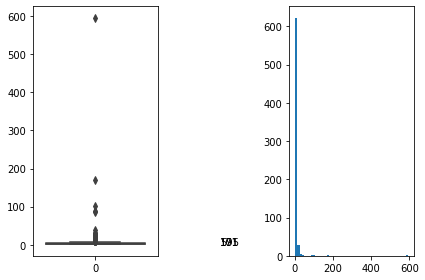

count
25 distinct values
117.0    56
111.0    56
51.0     49
62.0     45
159.0    40
86.0     35
92.0     35
26.0     35
109.0    34
28.0     28
13.0     24
16.0     22
37.0     22
14.0     22
133.0    21
18.0     21
22.0     19
31.0     18
52.0     15
11.0     14
39.0     13
21.0     12
38.0     10
12.0      9
23.0      7
Name: count, dtype: int64


sum
28 distinct values
227.0     56
193.0     56
95.0      45
1016.0    40
43.0      37
140.0     35
114.0     35
94.0      34
201.0     34
127.0     27
31.0      25
40.0      24
62.0      22
81.0      21
60.0      18
52.0      18
22.0      17
54.0      15
24.0      15
23.0      13
46.0      13
34.0      13
38.0      10
29.0       9
48.0       9
21.0       8
36.0       7
41.0       6
Name: sum, dtype: int64




In [41]:
#Remove reviews from products that have too few reviews
df = train_df[train_df['count'] > 10]
#Remove reviews from products that have too few helpful votes
df = df[df['sum'] > 20]

print('Number of reviews removed: '+ str(len(train_df)-len(df)))

float_cols = ['data/helpful_votes']
cat_cols = ['count','sum']
visualize_columns(float_cols,cat_cols,df)
train_df = df

# Create Our Target Variable: Determine the right metrics for usefulness

The next important task is how to measure the usefulness of a review in relation to its product. Absolute number does not make sense when we have products with various level of engagement and history. In the following, we attempt to (1) scale the absolute reviews by the total useful reviews a product have or (2) scale by max and min of the product it belongs to

helpful_votes_scaled_1
[0.6829268292682927, 0.5856299212598425, 0.5625]
0.0


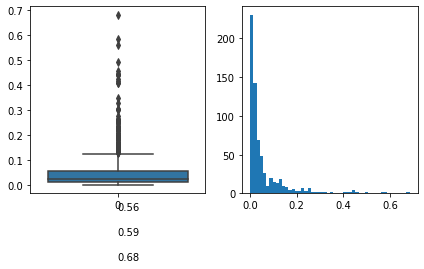

helpful_1
2 distinct values
False    550
True     112
Name: helpful_1, dtype: int64




In [45]:
#scale the absolute reviews by the total useful reviews a product have
USEFULNESS_THRESHOLD = 0.10

train_df['helpful_votes_scaled_1'] = train_df['data/helpful_votes'] / train_df['sum']
train_df['helpful_1'] = np.where(train_df['helpful_votes_scaled_1'] >= USEFULNESS_THRESHOLD,True,False)
float_cols = ['helpful_votes_scaled_1']
cat_cols = ['helpful_1']
visualize_columns(float_cols,cat_cols,train_df)

The scaled target variable new distribution looks a little cleaner, more like a exponential distribution although still a lot of low values

In [97]:
def MinMaxScale(row):
  x = row['data/helpful_votes']
  min = row['min']
  max = row['max']
  if max - min != 0 :
    return (x - min) /(max - min)
  else:
    return 0

0.3
helpful_votes_scaled_2
[1.0, 1.0, 1.0]
0.0


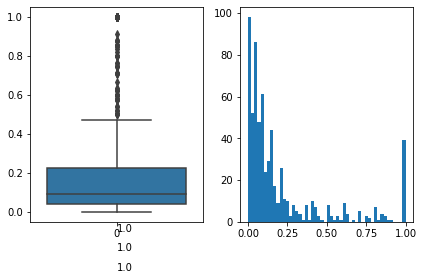

helpful_2
2 distinct values
False    526
True     136
Name: helpful_2, dtype: int64




In [48]:
#scale by max and min of the product it belongs to
TOP_K_PERCENT = 20
# #Scaled by max-min of dataset
# scaler = MinMaxScaler()
train_df['helpful_votes_scaled_2'] = train_df.apply(lambda row: MinMaxScale(row),axis=1)
# Find the minimum value of the top K percent records
USEFULNESS_THRESHOLD = np.min(train_df.nlargest(int(len(train_df)*TOP_K_PERCENT/100),'helpful_votes_scaled_2')['helpful_votes_scaled_2'])
print(USEFULNESS_THRESHOLD)
train_df['helpful_2'] = np.where(train_df['helpful_votes_scaled_2'] >= USEFULNESS_THRESHOLD,True,False)
float_cols = ['helpful_votes_scaled_2']
cat_cols = ['helpful_2']
visualize_columns(float_cols,cat_cols,train_df)

The distribution looks more spread out. Let's examine top 10 and bottom 10 lowest scaled helpful votes to decide which approach is more favorable

In [50]:
train_df.nlargest(10,'helpful_votes_scaled_2')

,data/helpful_votes,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_headline,data/review_id,data/star_rating,data/total_votes,count,sum,min,max,helpful_votes_scaled,helpful,helpful_votes_scaled_1,helpful_1,helpful_votes_scaled_2,helpful_2
137,10,b'B000OQ74FE',b'447336068',"b'HEAD Liquidmetal 4 Tennis Racquet (4-3/8), S...","b""I'm really impressed by the quality of this ...",b'Liquidmetal 4 makes you play like the BIG 4',b'R2EYR2BSLOHCF5',5,10,22.0,38.0,0.0,10.0,0.263158,True,0.263158,True,1.0,True
239,89,b'B000OQ8OU8',b'547332048',b'HEAD Ti.S6 Tennis Racquet - Strung',"b""I was on my high school tennis team almost 4...",b'Outstanding for returning recreational players',b'R3DF8ED26I7Y24',5,92,109.0,201.0,0.0,89.0,0.442786,True,0.442786,True,1.0,True
328,11,b'B001PN0A1U',b'351197271',b'Prince O3 Red MP+ Prestrung Tennis Racquet',"b""Just wanted to say how pleased I am with thi...",b'Terrific Stick',b'R4VHJ9DMTMLMZ',5,11,39.0,43.0,0.0,11.0,0.255814,True,0.255814,True,1.0,True
376,8,b'B000QX9SAE',b'53048323',b'Wilson Impact Tennis Racquet (Colors May Vary)',"b""I have used a few different racquets lately,...","b""It's a good racket!""",b'R2OJBCIDIO6CZP',3,8,26.0,29.0,0.0,8.0,0.275862,True,0.275862,True,1.0,True
379,5,b'B000V1O55Y',b'179386855',b'Head Intelligence I.S12 Tennis Racquet Racket',"b'The i.S12 is a true lightweight, I like to ...",b'Best Racquet in its range!',b'R3CMGHQ2K5QQ9Z',5,5,16.0,21.0,0.0,5.0,0.238095,True,0.238095,True,1.0,True
610,23,b'B000OQBPOK',b'726880504',b'HEAD Liquidmetal 4 Prestrung Tennis Racquets',b'I first bought this racquet in 2004 when it ...,b'Great high school varsity racquet',b'R1BOZ1PM7XYWOE',5,28,22.0,52.0,0.0,23.0,0.442308,True,0.442308,True,1.0,True
666,10,b'B0030GGXWA',b'525218499',b'Head Micro Gel Radical OS Strung Tennis Racq...,b'After using a $20 walmart racquet for a whil...,b'A great upgrade!!! Great for shoulder injury',b'R1JQC2V587Z7I4',5,10,28.0,43.0,0.0,10.0,0.232558,True,0.232558,True,1.0,True
840,16,b'B0038N9JF8',b'966478416',b'Babolat AeroPro Drive GT 2010 Tennis Racquet...,"b""I got this amazing babolat aeropro drive gt ...",b'Best racquet ever!',b'R30XZFDTHUGUGI',5,16,11.0,36.0,0.0,16.0,0.444444,True,0.444444,True,1.0,True
1004,14,b'B004UX3Z1E',b'19173789',b'Le Petit Tennis Racquet 17 Inches + TENNIS B...,b'I purchased this particular racquet for my 3...,b'Tennis Racquet for Toddlers',b'R3HNVAQ5QNBZCV',5,14,37.0,62.0,0.0,14.0,0.225806,True,0.225806,True,1.0,True
1173,31,b'B007WZZ3TE',b'489292521',b'DHS Table Tennis Racket 4002C Ping Pong Padd...,"b""Not forgiving, very sticky (when kept clean)...",b'Great Intermediate Paddle',b'R2ESB7YQWZZFTP',5,34,92.0,140.0,0.0,31.0,0.221429,True,0.221429,True,1.0,True


In [51]:
train_df.nsmallest(10,'helpful_votes_scaled_2')

,data/helpful_votes,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_headline,data/review_id,data/star_rating,data/total_votes,count,sum,min,max,helpful_votes_scaled,helpful,helpful_votes_scaled_1,helpful_1,helpful_votes_scaled_2,helpful_2
1340,1,b'B006A2X7GG',b'282976541',b'Head You Tek IG Radical MP Tennis Racquet Un...,b'Certainly a step up from the LiquidMetal 4 I...,b'Nice racquet.',b'RG305CR3KBYQV',5,1,13.0,31.0,1.0,8.0,0.032258,False,0.032258,False,0.000000,False
2062,1,b'B006A2X2PC',b'282976541',b'Head You Tek IG Radical MP Tennis Racquet Un...,b'This product was exactly as described and ca...,b'Exactly as described.',b'RGAK1V8ZPZFHH',5,1,13.0,31.0,1.0,8.0,0.032258,False,0.032258,False,0.000000,False
2093,1,b'B006A2X4OQ',b'282976541',b'Head You Tek IG Radical MP Tennis Racquet Un...,b'My instructor recommended this raquet. It is...,b'Excellent Raquet',b'R1XSNVCB0FH527',5,1,13.0,31.0,1.0,8.0,0.032258,False,0.032258,False,0.000000,False
2192,1,b'B006A2X4OQ',b'282976541',b'Head You Tek IG Radical MP Tennis Racquet Un...,"b'This racquet its great! Very light, high pre...",b'Love it',b'R31F7EZ0J75KPK',5,1,13.0,31.0,1.0,8.0,0.032258,False,0.032258,False,0.000000,False
2241,1,b'B006A2XB3U',b'282976541',b'Head You Tek IG Radical MP Tennis Racquet Un...,b'so so',b'Four Stars',b'RZJCSAS39OKEY',4,2,13.0,31.0,1.0,8.0,0.032258,False,0.032258,False,0.000000,False
2548,1,b'B006A2XB3U',b'282976541',b'Head You Tek IG Radical MP Tennis Racquet Un...,b'Great racket! Easy to use. Long swing type o...,b'Five Stars',b'R2YAUA0LMPFETS',5,1,13.0,31.0,1.0,8.0,0.032258,False,0.032258,False,0.000000,False
3850,1,b'B006A2X4OQ',b'282976541',b'Head You Tek IG Radical MP Tennis Racquet Un...,b'Great product!',b'Five Stars',b'R31VAIDNB59POW',5,2,13.0,31.0,1.0,8.0,0.032258,False,0.032258,False,0.000000,False
4064,1,b'B006A2X2PC',b'282976541',b'Head You Tek IG Radical MP Tennis Racquet Un...,b'The racket is great! But the strings with it...,b'The racket is great! But the strings with it...,b'R1P9DNACDU2DD4',5,1,13.0,31.0,1.0,8.0,0.032258,False,0.032258,False,0.000000,False
166,1,b'B00SC49H3W',b'453459277',b'Wilson US Open Junior Tennis Racquet',"b""I bought this for my 9 year old daughter and...",b'... my 9 year old daughter and racquet size ...,b'R2G4CI8BM1E8YL',5,1,159.0,1016.0,0.0,595.0,0.000984,False,0.000984,False,0.001681,False
269,1,b'B00BCP4WHY',b'453459277',b'Wilson US Open Junior Tennis Racquet',"b'perfect racquet for my son 4 years, is light...",b'Perfect racquet',b'R1O87796UWJCFD',5,2,159.0,1016.0,0.0,595.0,0.000984,False,0.000984,False,0.001681,False


The results looks as expected. Let's go with the 2nd scaling approach.

#Text Preprocessing

Tokenization

In [52]:
tokenizer = RegexpTokenizer(r'\w+')

Stopping

In [53]:
nltk_stpwd = stopwords.words('english')
stop_words_stpwd = get_stop_words('en')
custom_stpwd = ['b','br',] # These get added after inspecting the listing of stemmed tokens
merged_stopwords = list(set(nltk_stpwd + stop_words_stpwd + custom_stpwd))

print(len(set(merged_stopwords)))
print(merged_stopwords[:10])

213
['only', 'does', 's', "i'm", 'itself', 'herself', "didn't", "let's", 'myself', 'so']


Stemming

In [54]:
sb_stemmer = SnowballStemmer('english')

# Transform Reviews Text to Term Frequency - IDF Vector

In [55]:
def tokenize_stop_stem_text(document):
  tokens = tokenizer.tokenize(document.lower())
  stopped_tokens = [token for token in tokens if not token in merged_stopwords]
  stemmed_tokens = [sb_stemmer.stem(token) for token in stopped_tokens]
  return stemmed_tokens

In [56]:
num_reviews = train_df.shape[0]
# Stripping leading and trailing characters
train_df['data/review_body'] = train_df['data/review_body'].str.strip("b\'\"")
# Removing any digits
train_df['data/review_body'] = train_df['data/review_body'].str.replace(r'\d+','')
# Load reviews into list
doc_set = [train_df['data/review_body'].iloc[i] for i in range(num_reviews)]
texts = []

for doc in doc_set:
  # putting our three steps together
  results = tokenize_stop_stem_text(doc)
  #print(stemmed_tokens) #Uncomment to inspect the results of tokenizations
  # add tokens to list
  texts.append(results)

print(texts[0])

['suppos', 'one', 'best', 'novic', 'racquet', 'bought', 'daughter', 'birthday', 'degre', 'outsid', 'ask', 'next', 'summer']


In [57]:
# Gensim's Dictionary encapsulates the mapping between normalized words and their integer ids.
texts_dict = corpora.Dictionary(texts)
# Examine each token’s unique id
print(texts_dict)

Dictionary(2767 unique tokens: ['ask', 'best', 'birthday', 'bought', 'daughter']...)


In [58]:
LOWER_BOUND = 5
UPPER_BOUND = 0.25
texts_dict.filter_extremes(no_below=LOWER_BOUND, no_above=UPPER_BOUND) # inplace filter
print(texts_dict)
print("top terms:")
print(sorted(texts_dict.token2id.items(), key=operator.itemgetter(1), reverse = False)[:10])

Dictionary(741 unique tokens: ['ask', 'best', 'bought', 'daughter', 'next']...)
top terms:
[('ask', 0), ('best', 1), ('bought', 2), ('daughter', 3), ('next', 4), ('summer', 5), ('suppos', 6), ('came', 7), ('cover', 8), ('extra', 9)]


In [59]:
texts_dict.save(home_dir+'tennis_racquet_review.dict') # lets save to disk for later use

In [60]:
corpus = [texts_dict.doc2bow(text) for text in texts]
len(corpus)
pickle.dump(corpus, open(home_dir+'tennis_racquet_review.pkl', 'wb'))

#Train LDA Model

In [63]:
def train_LDA(corpus,dictionary,NUM_TOPICS=1,new_train=True):
  MDL = 'model{0}.gensim'.format(NUM_TOPICS)
  if new_train:
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, 
                                              id2word=dictionary, passes=15,iterations=5000, # to make sure enough random starts
                                              random_state=random.seed(12345), # to make sure results are the same every run
                                              minimum_probability=0.0001) #to make sure no topics are filtered out
    ldamodel.save(home_dir+MDL)
  else:
    ldamodel = gensim.models.ldamodel.LdaModel.load(home_dir+MDL)

  #Print top 10 words from each topics
  topics = ldamodel.print_topics(num_words=10)
  for topic in topics:
      print(topic)
  return ldamodel
  

In [66]:
k=4
mdl = train_LDA(corpus,texts_dict,k,True)
#Visualize LDA results
lda_display = pyLDAvis.gensim.prepare(mdl, corpus, texts_dict, sort_topics=False)
pyLDAvis.display(lda_display)

(0, '0.018*"ball" + 0.015*"year" + 0.015*"like" + 0.014*"feel" + 0.014*"love" + 0.014*"light" + 0.013*"power" + 0.013*"player" + 0.012*"old" + 0.011*"size"')
(1, '0.083*"string" + 0.027*"machin" + 0.016*"clamp" + 0.015*"get" + 0.014*"job" + 0.013*"time" + 0.012*"tension" + 0.012*"stringer" + 0.011*"first" + 0.009*"klipperm"')
(2, '0.014*"control" + 0.014*"power" + 0.012*"paddl" + 0.012*"head" + 0.011*"spin" + 0.011*"string" + 0.011*"much" + 0.010*"weight" + 0.009*"like" + 0.008*"game"')
(3, '0.037*"grip" + 0.022*"bag" + 0.018*"fit" + 0.013*"raquet" + 0.013*"product" + 0.012*"like" + 0.012*"two" + 0.012*"qualiti" + 0.010*"look" + 0.008*"replac"')


# Training the LDA models with different values of K (Number of topics as assumptions)

In [67]:
k=3
mdl = train_LDA(corpus,texts_dict,k,True)
#Visualize LDA results
lda_display = pyLDAvis.gensim.prepare(mdl, corpus, texts_dict, sort_topics=False)
pyLDAvis.display(lda_display)

(0, '0.070*"string" + 0.021*"machin" + 0.015*"get" + 0.014*"clamp" + 0.013*"time" + 0.012*"job" + 0.011*"first" + 0.010*"tension" + 0.009*"stringer" + 0.008*"hour"')
(1, '0.020*"ball" + 0.018*"love" + 0.017*"like" + 0.017*"old" + 0.016*"year" + 0.016*"perfect" + 0.014*"player" + 0.012*"size" + 0.011*"light" + 0.011*"price"')
(2, '0.019*"power" + 0.014*"grip" + 0.014*"feel" + 0.013*"head" + 0.011*"control" + 0.011*"spin" + 0.011*"game" + 0.010*"string" + 0.010*"like" + 0.010*"much"')


In [68]:
k=6
mdl = train_LDA(corpus,texts_dict,k,True)
#Visualize LDA results
lda_display = pyLDAvis.gensim.prepare(mdl, corpus, texts_dict, sort_topics=False)
pyLDAvis.display(lda_display)

(0, '0.058*"string" + 0.025*"machin" + 0.013*"get" + 0.011*"clamp" + 0.010*"time" + 0.010*"first" + 0.009*"gamma" + 0.009*"also" + 0.009*"go" + 0.009*"review"')
(1, '0.018*"bag" + 0.017*"fit" + 0.016*"ball" + 0.016*"perfect" + 0.015*"like" + 0.013*"light" + 0.012*"look" + 0.011*"get" + 0.011*"nice" + 0.011*"size"')
(2, '0.018*"player" + 0.017*"feel" + 0.016*"power" + 0.015*"head" + 0.011*"much" + 0.010*"like" + 0.010*"swing" + 0.010*"weight" + 0.010*"recommend" + 0.010*"price"')
(3, '0.021*"buy" + 0.021*"product" + 0.015*"purchas" + 0.014*"string" + 0.013*"grip" + 0.012*"year" + 0.012*"excel" + 0.012*"like" + 0.011*"clamp" + 0.010*"get"')
(4, '0.079*"string" + 0.015*"machin" + 0.014*"tension" + 0.014*"get" + 0.013*"job" + 0.012*"time" + 0.012*"clamp" + 0.011*"first" + 0.009*"stringer" + 0.009*"easi"')
(5, '0.025*"ball" + 0.019*"love" + 0.018*"year" + 0.017*"power" + 0.015*"old" + 0.014*"grip" + 0.014*"feel" + 0.013*"serv" + 0.012*"like" + 0.012*"size"')


K = 3 seems to yield enough distance between topics and within topics.
It seems most good review going into our model touched on these 3 topics:

1 . String Tension ('0.070*"string" + 0.021*"machin" + 0.015*"get" + 0.014*"clamp" + 0.013*"time" + 0.012*"job" + 0.011*"first" + 0.010*"tension")

2 . User Subjectivity and Experience ('0.020*"ball" + 0.018*"love" + 0.017*"like" + 0.017*"old" + 0.016*"year" + 0.016*"perfect" + 0.014*"player" + 0.012*"size" + 0.011*"light")

3 . Power and Control (0.019*"power" + 0.014*"grip" + 0.014*"feel" + 0.013*"head" + 0.011*"control" + 0.011*"spin")

#Explore topics distribution prediction of sample reviews (1,2 from highly useful and 1,2 from not useful)

In [70]:
train_df.nlargest(20,'helpful_votes_scaled_2')

,data/helpful_votes,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_headline,data/review_id,data/star_rating,data/total_votes,count,sum,min,max,helpful_votes_scaled,helpful,helpful_votes_scaled_1,helpful_1,helpful_votes_scaled_2,helpful_2
137,10,b'B000OQ74FE',b'447336068',"b'HEAD Liquidmetal 4 Tennis Racquet (4-3/8), S...",I'm really impressed by the quality of this ra...,b'Liquidmetal 4 makes you play like the BIG 4',b'R2EYR2BSLOHCF5',5,10,22.0,38.0,0.0,10.0,0.263158,True,0.263158,True,1.0,True
239,89,b'B000OQ8OU8',b'547332048',b'HEAD Ti.S6 Tennis Racquet - Strung',I was on my high school tennis team almost ye...,b'Outstanding for returning recreational players',b'R3DF8ED26I7Y24',5,92,109.0,201.0,0.0,89.0,0.442786,True,0.442786,True,1.0,True
328,11,b'B001PN0A1U',b'351197271',b'Prince O3 Red MP+ Prestrung Tennis Racquet',Just wanted to say how pleased I am with this ...,b'Terrific Stick',b'R4VHJ9DMTMLMZ',5,11,39.0,43.0,0.0,11.0,0.255814,True,0.255814,True,1.0,True
376,8,b'B000QX9SAE',b'53048323',b'Wilson Impact Tennis Racquet (Colors May Vary)',"I have used a few different racquets lately, a...","b""It's a good racket!""",b'R2OJBCIDIO6CZP',3,8,26.0,29.0,0.0,8.0,0.275862,True,0.275862,True,1.0,True
379,5,b'B000V1O55Y',b'179386855',b'Head Intelligence I.S12 Tennis Racquet Racket',"The i.S is a true lightweight, I like to swin...",b'Best Racquet in its range!',b'R3CMGHQ2K5QQ9Z',5,5,16.0,21.0,0.0,5.0,0.238095,True,0.238095,True,1.0,True
610,23,b'B000OQBPOK',b'726880504',b'HEAD Liquidmetal 4 Prestrung Tennis Racquets',I first bought this racquet in when it was to...,b'Great high school varsity racquet',b'R1BOZ1PM7XYWOE',5,28,22.0,52.0,0.0,23.0,0.442308,True,0.442308,True,1.0,True
666,10,b'B0030GGXWA',b'525218499',b'Head Micro Gel Radical OS Strung Tennis Racq...,"After using a $ walmart racquet for a while, I...",b'A great upgrade!!! Great for shoulder injury',b'R1JQC2V587Z7I4',5,10,28.0,43.0,0.0,10.0,0.232558,True,0.232558,True,1.0,True
840,16,b'B0038N9JF8',b'966478416',b'Babolat AeroPro Drive GT 2010 Tennis Racquet...,I got this amazing babolat aeropro drive gt on...,b'Best racquet ever!',b'R30XZFDTHUGUGI',5,16,11.0,36.0,0.0,16.0,0.444444,True,0.444444,True,1.0,True
1004,14,b'B004UX3Z1E',b'19173789',b'Le Petit Tennis Racquet 17 Inches + TENNIS B...,I purchased this particular racquet for my yr...,b'Tennis Racquet for Toddlers',b'R3HNVAQ5QNBZCV',5,14,37.0,62.0,0.0,14.0,0.225806,True,0.225806,True,1.0,True
1173,31,b'B007WZZ3TE',b'489292521',b'DHS Table Tennis Racket 4002C Ping Pong Padd...,"Not forgiving, very sticky (when kept clean). ...",b'Great Intermediate Paddle',b'R2ESB7YQWZZFTP',5,34,92.0,140.0,0.0,31.0,0.221429,True,0.221429,True,1.0,True


In [72]:
train_df.nsmallest(20,'helpful_votes_scaled_2')

,data/helpful_votes,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_headline,data/review_id,data/star_rating,data/total_votes,count,sum,min,max,helpful_votes_scaled,helpful,helpful_votes_scaled_1,helpful_1,helpful_votes_scaled_2,helpful_2
1340,1,b'B006A2X7GG',b'282976541',b'Head You Tek IG Radical MP Tennis Racquet Un...,Certainly a step up from the LiquidMetal I wa...,b'Nice racquet.',b'RG305CR3KBYQV',5,1,13.0,31.0,1.0,8.0,0.032258,False,0.032258,False,0.000000,False
2062,1,b'B006A2X2PC',b'282976541',b'Head You Tek IG Radical MP Tennis Racquet Un...,This product was exactly as described and came...,b'Exactly as described.',b'RGAK1V8ZPZFHH',5,1,13.0,31.0,1.0,8.0,0.032258,False,0.032258,False,0.000000,False
2093,1,b'B006A2X4OQ',b'282976541',b'Head You Tek IG Radical MP Tennis Racquet Un...,My instructor recommended this raquet. It is m...,b'Excellent Raquet',b'R1XSNVCB0FH527',5,1,13.0,31.0,1.0,8.0,0.032258,False,0.032258,False,0.000000,False
2192,1,b'B006A2X4OQ',b'282976541',b'Head You Tek IG Radical MP Tennis Racquet Un...,"This racquet its great! Very light, high preci...",b'Love it',b'R31F7EZ0J75KPK',5,1,13.0,31.0,1.0,8.0,0.032258,False,0.032258,False,0.000000,False
2241,1,b'B006A2XB3U',b'282976541',b'Head You Tek IG Radical MP Tennis Racquet Un...,so so,b'Four Stars',b'RZJCSAS39OKEY',4,2,13.0,31.0,1.0,8.0,0.032258,False,0.032258,False,0.000000,False
2548,1,b'B006A2XB3U',b'282976541',b'Head You Tek IG Radical MP Tennis Racquet Un...,Great racket! Easy to use. Long swing type of ...,b'Five Stars',b'R2YAUA0LMPFETS',5,1,13.0,31.0,1.0,8.0,0.032258,False,0.032258,False,0.000000,False
3850,1,b'B006A2X4OQ',b'282976541',b'Head You Tek IG Radical MP Tennis Racquet Un...,Great product!,b'Five Stars',b'R31VAIDNB59POW',5,2,13.0,31.0,1.0,8.0,0.032258,False,0.032258,False,0.000000,False
4064,1,b'B006A2X2PC',b'282976541',b'Head You Tek IG Radical MP Tennis Racquet Un...,The racket is great! But the strings with it i...,b'The racket is great! But the strings with it...,b'R1P9DNACDU2DD4',5,1,13.0,31.0,1.0,8.0,0.032258,False,0.032258,False,0.000000,False
166,1,b'B00SC49H3W',b'453459277',b'Wilson US Open Junior Tennis Racquet',I bought this for my year old daughter and ra...,b'... my 9 year old daughter and racquet size ...,b'R2G4CI8BM1E8YL',5,1,159.0,1016.0,0.0,595.0,0.000984,False,0.000984,False,0.001681,False
269,1,b'B00BCP4WHY',b'453459277',b'Wilson US Open Junior Tennis Racquet',"perfect racquet for my son years, is light, p...",b'Perfect racquet',b'R1O87796UWJCFD',5,2,159.0,1016.0,0.0,595.0,0.000984,False,0.000984,False,0.001681,False


In [73]:
sample_review_pos_1 = final_data['data/review_body'].iloc[2176]
print(sample_review_pos_1)
sample_review_pos_2 = final_data['data/review_body'].iloc[1602]
print(sample_review_pos_2)
sample_review_neg_1 = final_data['data/review_body'].iloc[4563]
print(sample_review_neg_1)
sample_review_neg_2 = final_data['data/review_body'].iloc[477]
print(sample_review_neg_2)

b"Basically, I'm a 58 year old recreational 4.5 NTSC player in the states and 30/2 player in France -- which is better than most, worse than many.<br /><br />What I use and why:  After MUCH experimentation using my own racquet stringing machine and lots of different strings and racquets, I found what works best for me and for many of my friends is this liquid metal 8 racquet restrung with Luxilon Original Rough string -16 gauge (1.30mm diameter) and strung at a shockingly low 33 pounds of tension (instead of the usual 55 lbs recommended).  Even 35 pounds was a bit too high as it sent balls sailing too far for me.  After a couple hours of use, the strings are broken in and stable and work well for me for about 60 hours playing time or 3 months at 5 hours a week on the courts.  When the strings stop recentering themselves after each shot, it's time to restring again at this low tension.  Never broke a string yet this way and even though it's a poly string, at 33 lbs it's very easy on the

In [74]:
MDL = 'model3.gensim'
ldamodel = gensim.models.ldamodel.LdaModel.load(home_dir+MDL)
def return_topics_distribution(document,dictionary=texts_dict,lda=ldamodel):
  clean_doc = tokenize_stop_stem_text(document)
  bow = dictionary.doc2bow(clean_doc)
  new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])
  return new_doc_distribution

In [75]:
print(return_topics_distribution(sample_review_pos_1))
print(return_topics_distribution(sample_review_pos_2))
print(return_topics_distribution(sample_review_neg_1))
print(return_topics_distribution(sample_review_neg_1))

[0.16533077 0.0008503  0.833819  ]
[0.01094539 0.00997759 0.979077  ]
[0.08383927 0.8314761  0.08468465]
[0.08383925 0.8314768  0.08468395]


It looks like no useful reviews are alike, but bad reviews are similar to each other.

# Measuring similarity of new review to the trained LDA corpus

In [76]:
# we need to use nested list comprehension here
# this may take 1-2 minutes...
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in ldamodel[corpus]])
doc_topic_dist

array([[0.04663458, 0.90621775, 0.04714769],
       [0.03107712, 0.03279931, 0.9361236 ],
       [0.03451851, 0.9332573 , 0.03222418],
       ...,
       [0.02470714, 0.94617265, 0.0291202 ],
       [0.04420937, 0.24039742, 0.71539325],
       [0.05559305, 0.8933486 , 0.05105839]], dtype=float32)

In [77]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    sim=[distance.jensenshannon(data,query) for data in matrix]
    return sim

In [78]:
def get_most_similar_documents(query,matrix,k=5):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return np.argsort(sims)[:k] # the top k positional index of the smallest Jensen Shannon distances

# Investigating potential relationships between LDA model predictions and reviews usefulness


In [79]:
new_doc_distribution = return_topics_distribution(sample_review_pos_2)
most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)
print(most_sim_ids)
most_similar_df = train_df.iloc[most_sim_ids,:]
most_similar_df

[184 606 473 232 465]


,data/helpful_votes,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_headline,data/review_id,data/star_rating,data/total_votes,count,sum,min,max,helpful_votes_scaled,helpful,helpful_votes_scaled_1,helpful_1,helpful_votes_scaled_2,helpful_2
1602,17,b'B0034PBL7Y',b'389135987',b'Wilson Triumph Tennis Racquet without Cover',"Overall a decent beginner's racket, but not wi...",b'Loose Strings',b'R32M7D15A76195',3,17,13.0,40.0,0.0,17.0,0.425000,True,0.425000,True,1.000000,True
4774,8,b'B006A2X4OQ',b'282976541',b'Head You Tek IG Radical MP Tennis Racquet Un...,I'm relatively new to tennis and had the Radic...,b'Playing more tennis',b'R1CRO95VBJVV41',5,9,13.0,31.0,1.0,8.0,0.258065,True,0.258065,True,1.000000,True
3721,6,b'B000OQBPOK',b'726880504',b'HEAD Liquidmetal 4 Prestrung Tennis Racquets',This racquet replaced my oversized LM. It is ...,b'Way more accurate compared to oversized.',b'R1K74R6R1O22K6',5,6,22.0,52.0,0.0,23.0,0.115385,True,0.115385,True,0.260870,False
1944,1,b'B000OQBPOK',b'726880504',b'HEAD Liquidmetal 4 Prestrung Tennis Racquets',I bought it cause of the low price as my secon...,b'Nice racquet.',b'R3OFZ9WKFST75S',4,1,22.0,52.0,0.0,23.0,0.019231,False,0.019231,False,0.043478,False
3684,1,b'B0010BJ71G',b'179386855',b'Head Intelligence I.S12 Tennis Racquet Racket',I bought this racquet for my wife who is a beg...,b'Heavy Racquet and Oddly Shaped',b'R11EG5FD0BOB82',2,2,16.0,21.0,0.0,5.0,0.047619,False,0.047619,False,0.200000,False


In [81]:
new_doc_distribution = return_topics_distribution(sample_review_pos_1)
most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)
print(most_sim_ids)
most_similar_df = train_df.iloc[most_sim_ids,:]
most_similar_df

[264 603 440 586 329]


,data/helpful_votes,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_headline,data/review_id,data/star_rating,data/total_votes,count,sum,min,max,helpful_votes_scaled,helpful,helpful_votes_scaled_1,helpful_1,helpful_votes_scaled_2,helpful_2
2176,101,b'B000OQBP7C',b'384056751',b'Head Liquidmetal 8 Tennis Racquet',"Basically, I'm a year old recreational . NTSC...","b'Tried and Liked others costing up to $200., ...",b'R2Q926GXNLNNCY',5,105,117.0,227.0,0.0,101.0,0.444934,True,0.444934,True,1.000000,True
4764,10,b'B000N26HEI',b'108377324',b'Gamma Sports Tennis Racquet Leather Replacem...,i have been playing since i was yo. i have alw...,b'leather is better',b'RKAJ5EPIPK6CQ',5,10,26.0,40.0,0.0,10.0,0.250000,True,0.250000,True,1.000000,True
3498,2,b'B000OQBPQ8',b'547332048',b'HEAD Ti.S6 Tennis Racquet - Strung',Its just okay. I needed a lightweight racket d...,b'Hate the strings',b'R3BYGHERRPCIGC',3,3,109.0,201.0,0.0,89.0,0.009950,False,0.009950,False,0.022472,False
4645,5,b'B00138ZLD4',b'222823620',b'Luxilon ALU Power Spin 127 Tennis Racquet St...,Love this string because once it is strung tig...,b'great for top spin hard hitters',b'R1IV7UTXBF436K',5,6,21.0,31.0,0.0,8.0,0.161290,True,0.161290,True,0.625000,True
2644,5,b'B0000AQCUS',b'384056751',b'Head Liquidmetal 8 Tennis Racquet',"I received this racquet as a Christmas gift, i...",b'great tennis racquet',b'RRQIQ2L744RTU',5,7,117.0,227.0,0.0,101.0,0.022026,False,0.022026,False,0.049505,False


In [80]:
new_doc_distribution = return_topics_distribution(sample_review_neg_2)
most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)
print(most_sim_ids)
most_similar_df = train_df.iloc[most_sim_ids,:]
most_similar_df

[ 55 623 299 414 524]


,data/helpful_votes,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_headline,data/review_id,data/star_rating,data/total_votes,count,sum,min,max,helpful_votes_scaled,helpful,helpful_votes_scaled_1,helpful_1,helpful_votes_scaled_2,helpful_2
477,1,b'B00BCP4WHY',b'453459277',b'Wilson US Open Junior Tennis Racquet',Easy to use beginner tennis racket for my kids.,b'Four Stars',b'RXOT8OW8SDC84',4,2,159.0,1016.0,0.0,595.0,0.000984,False,0.000984,False,0.001681,False
4904,1,b'B00AY6DBW4',b'16849618',b'Wilson Energy Extra Large Tennis Racquet wit...,Great Buy and excellent quality,b'Great Buy and excellent quality',b'R6JCFN97NCLID',5,1,86.0,114.0,0.0,24.0,0.008772,False,0.008772,False,0.041667,False
2425,1,b'B0000AQAEZ',b'882115572',b'Head Tis5 Comfortzone Performance Tennis Rac...,"La raqueta no la habia probado, pero me acomod...",b'Me gusto',b'R23FFY15VSAJQ3',5,3,62.0,95.0,0.0,13.0,0.010526,False,0.010526,False,0.076923,False
3361,1,b'B00MT67USS',b'798215989',b'Wilson Pro Staff RF97 Autograph Tennis Racquet',Excellent racquet . Has a very good control on...,b'Excellent racquet. Has a very good control o...,b'RPKKSSUJB8J4V',5,1,14.0,52.0,0.0,17.0,0.019231,False,0.019231,False,0.058824,False
4106,1,b'B0090WWUMK',b'260363376',b'adidas Barricade III Tour 3 Tennis Racquet Bag',Awesome. Perfect size.,b'Five Stars',b'R12GTUIW48KUI4',5,1,38.0,22.0,0.0,5.0,0.045455,False,0.045455,False,0.200000,False


The most matching documents to the sample reviews seems to correlate with its actual usefulness.

#Predicting usefulness scores by averging the score of k most similar documents

In [83]:
def predict_usefulness_score(doc):
  new_doc_distribution = return_topics_distribution(doc)
  most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist,3)
  most_sim_df_scores = train_df.iloc[most_sim_ids,:]
  return np.mean(most_sim_df_scores['helpful_votes_scaled_2'])

In [92]:
print(predict_usefulness_score(sample_review_neg_2))
print(predict_usefulness_score(sample_review_pos_2))

0.05913775766716942
0.753623188405797


# Apply to entire dataset (which includes both seen and unseen data)

Seen data: low useful to high use, mostly low

Unseen data: all unuseful

In [93]:
#apply to entire train data set
final_data['predicted_score'] = final_data['data/review_body'].apply(predict_usefulness_score)
final_data.head(5)

,data/helpful_votes,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_headline,data/review_id,data/star_rating,data/total_votes,count,sum,min,max,predicted_score
0,1,b'B000OQ74FE',b'447336068',"b'HEAD Liquidmetal 4 Tennis Racquet (4-3/8), S...","b""Supposedly one of the best novice racquets. ...",b'highly rated',b'R12VYI1R99EI1Q',5,4,22.0,38.0,0.0,10.0,0.095368
1,1,b'B0034PBLA6',b'16849618',b'Wilson Energy Extra Large Tennis Racquet wit...,b'Wilson Energy Extra Large Tennis Racquet wit...,b'Wilson Energy Extra Large Tennis Racquet wit...,b'R31ZPNKKOSMF2L',3,5,86.0,114.0,0.0,24.0,0.109361
2,0,b'B006A2V4KC',b'81787317',b'Head Youtek IG Prestige Pro Tennis Racquet (...,"b""I've been playing with Head Racquets for man...",b'Best of the Prestige frames',b'R2NOC0IE7BEWWN',5,0,5.0,8.0,0.0,6.0,0.174423
3,0,b'B000OQBP7C',b'384056751',b'Head Liquidmetal 8 Tennis Racquet',b'I chose this racquet because its price and w...,b'Great!!!',b'R2IDP12RDJ1SB5',5,1,117.0,227.0,0.0,101.0,0.062595
4,1,b'B004IA8GL8',b'586581984',"b""Wilson unstrung'11 Blade Lite BLX Tennis Rac...",b'The racket is really nice for $60+. There is...,b'Good racket',b'R2VG95KHXUZG1S',4,1,6.0,6.0,0.0,2.0,0.048935


In [94]:
#save it
predicted_data = 'US_Tennis_Racquet_Reviews_Predictions.csv'
final_data.to_csv(home_dir+predicted_data)

# Visualize the results

In [95]:
#load saved prediction data. Uncomment if needed
predicted_data = 'US_Tennis_Racquet_Reviews_Predictions.csv'
final_data = pd.read_csv(home_dir+predicted_data)

Regression approach: see how far our predictions deviates from actual values

In [98]:
final_data['helpful_votes_scaled_2'] = final_data.apply(lambda row: MinMaxScale(row),axis=1)

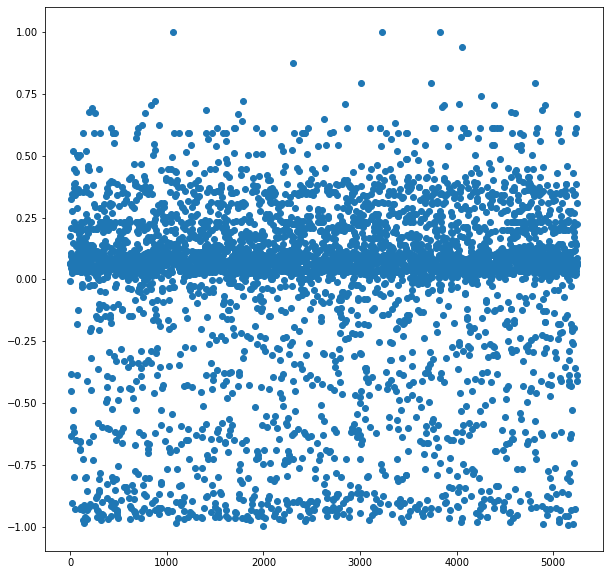

In [100]:
true_vals = final_data['helpful_votes_scaled_2']
predicted_vals = final_data['predicted_score']
plt.figure(figsize=(10,10))
plt.plot(predicted_vals - true_vals,marker='o',linestyle='')
plt.show()

Or if a visiable line can be detected:

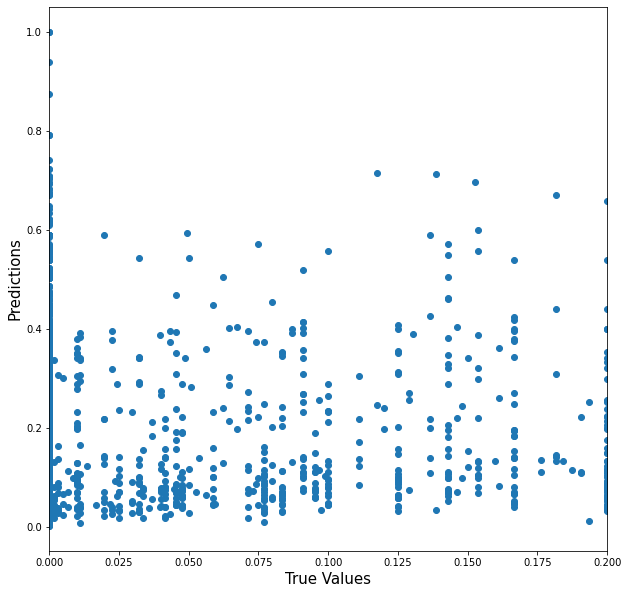

In [102]:
true_vals = final_data['helpful_votes_scaled_2']
predicted_vals = final_data['predicted_score']
plt.figure(figsize=(10,10))
plt.scatter(true_vals, predicted_vals)
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.xlim(0,0.2)
plt.show()

Classification approach: how accurate our model predicts based on a arbitrary cutoff value

In [107]:
CUT_OFF_VALUE = 0.50
final_data['predicted_class'] = np.where(final_data['predicted_score'] >= CUT_OFF_VALUE,True,False)
final_data['actual_class'] = np.where(final_data['helpful_votes_scaled_2'] >= CUT_OFF_VALUE,True,False)
pd.crosstab(final_data['actual_class'],final_data['predicted_class'],
            margins_name="Total",rownames=['Actual Class'], colnames=['Predicted Class'],normalize=False)


Predicted Class,False,True
Actual Class,,
False,4230,210
True,731,81


In [108]:
# A cleaner way to report classification metrics
y_test = final_data['actual_class']
y_pred = final_data['predicted_class']
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.8208301599390708
[[4230  210]
 [ 731   81]]
              precision    recall  f1-score   support

       False       0.85      0.95      0.90      4440
        True       0.28      0.10      0.15       812

    accuracy                           0.82      5252
   macro avg       0.57      0.53      0.52      5252
weighted avg       0.76      0.82      0.78      5252

